In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd
import sympy as sym
from odeintw import odeintw
import multitype_new as mt
import importlib
importlib.reload(mt)
from scipy.integrate import odeint

In [75]:
idx = 0
gamma = 0.25#1/7 #0.4 # Recovery Rate
sigma = 1/3 #0.3 # Progression rate from exposed to infectious

# Outputs from MATLAB for parsimonious model

beta_vec = np.array([0.3225,	0.415,	0.47,	0.6025,	0.8775])
# Reff_vec = np.array((2., 2.5, 3., 3.5, 4.))

# R for the actual model is calculated later, labelled R_effective
Reff_vec = beta_vec / gamma
RV = Reff_vec[idx]
ntypes = 8
# Number of types-at-birth
nexposed = int(ntypes/2)
# Disease Parameters


beta_baseline = beta_vec[idx]
RV = beta_baseline / gamma
epsilon = 1e-3

Tmax = 1000 
num = Tmax 
time = np.linspace(0, Tmax, num=num)
dtime = time[1]-time[0]


# Proportion of population in each type
# p_vac = 0.7
# p_no_vac = 1- p_vac 

# p_rec = 0.2 # % recovered from previous strains
# p_sus = 1-p_rec # % never infected with any coronavirus

# Reduced susceptibility for each type based on infection/vaccine immunity
const_vec = np.squeeze(pd.read_csv('const_vec_in.csv',header=None).values) #np.array((1., sus_ur, sus_vu, sus_vr))
prop_vec = np.squeeze(pd.read_csv('prop_vec_in.csv',header=None).values) #np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_vac, p_rec*p_vac))
scale = const_vec*prop_vec


# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

im = 0
im_vec = np.zeros(ntypes)
y0 = np.zeros(ntypes)
y0[0] = 1
ics = np.zeros(ntypes)
def eta(t):
    return im_vec

# No reduction in transmission conferred by vaccination
trans_vec = np.ones(nexposed)


In [77]:
print(const_vec)
print(prop_vec)

[1.  0.6 0.6 0.6]
[0.09393798 0.16031202 0.44515626 0.30059374]


In [78]:
Reff_vec

array([1.29, 1.66, 1.88, 2.41, 3.51])

In [79]:
def lifetime_vec(beta, gamma, sigma, ntypes = ntypes, const_vec = const_vec, prop_vec = prop_vec, trans_vec = trans_vec):
    nexposed = int(ntypes / 2)
    omega_vec = sigma * np.ones(ntypes) 

        
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta)*trans_vec[nex] + gamma
    return omega_vec

omega_vec = lifetime_vec(beta_baseline, gamma, sigma)

def P(u, t): # Offspring distribution

        ## Returns a vector of length ntypes with entry i containing  probabilities of generating particles 
        ## of each type from a particle of type i

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_baseline) + gamma)
        

        sum_gen_funcs = np.sum((beta_baseline*prop_vec/omega)*const_vec*u[:nexposed])
         
        for nex in range(0, nexposed):

            pvec[nex] = u[nex+nexposed] 
            pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs  + (gamma/omega)
        
        return pvec  

def Jacobian_mat(beta, gamma, sigma, ntypes = ntypes, const_vec = const_vec, prop_vec = prop_vec, omega_vec = omega_vec):
    Omat = np.zeros((ntypes, ntypes))
    omega_vec = sigma * np.ones(ntypes)       
    nexposed = int(ntypes/2)
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta) + gamma
        Omat[nex, nex+nexposed] = omega_vec[nex]
        Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta 
        Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta * prop_vec)

    Omat -= np.diag(omega_vec)
    return Omat
rho = (odeint(mt.set_odes, ics, time, args = (P, omega_vec)).T )
q = np.ones_like(time)
for i in range(ntypes):
    q *= rho[i, :] ** y0[i]

In [98]:
Omat = Jacobian_mat(beta_baseline, gamma, sigma)
def deriv(u, t):
    return u@Omat

sol1 = np.sum(sp.integrate.odeint(deriv, y0, time), axis = 1)

In [99]:
Sigma_mat = Jacobian_mat(beta_baseline, gamma, sigma).T
Sigma_mat[nexposed:, :nexposed] = 0
T_mat = Jacobian_mat(beta_baseline, gamma, sigma) - Sigma_mat
next_gen = - T_mat @ nla.inv(Sigma_mat)
R_effective = np.real_if_close(np.max(nla.eigvals(next_gen)))
print('Effective Reproduction number is: ' + str(R_effective))

Effective Reproduction number is: 0.8578746751900409


In [104]:
read_I_VOC = 0
if read_I_VOC:
    I_VOC = np.genfromtxt('./I_VOC.csv')

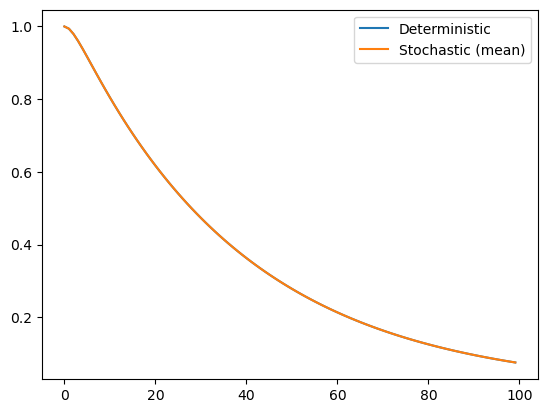

In [101]:
N = 66000000 # population of UK
I0 = y0[0]
S0 = N-I0
ics_S = S0*prop_vec
ics_E = np.array((I0, 0, 0, 0))
ics_all = np.concatenate((ics_S, ics_E, np.zeros(4)))
def model_deterministic(u, t):
    # u[:4] are susceptibles, u[4:8] are exposed and u[8:] are infectious of types 1-4 
    # It doesn't matter which type of I you are infected with, but transmission is scaled 
    # depending on the type of S that you are. 
    dS = - beta_baseline * np.sum(u[8:])* const_vec * u[:4] / N
    dE = beta_baseline * np.sum(u[8:])* const_vec * u[:4] / N - sigma * u[4:8]
    dI = sigma * u[4:8] - gamma * u[8:]
    return np.concatenate((dS, dE, dI))

plt.plot(time[:100], np.sum(odeint(model_deterministic, ics_all, time)[:, 4:], axis = 1)[:100], label = 'Deterministic')
plt.plot(time[:100], sol1[:100], label = 'Stochastic (mean)')
# plt.plot(I_VOC, label = 'I_VOC')
plt.legend()

In [92]:
def find_beta(beta):
    Sigma_mat = Jacobian_mat(beta, gamma, sigma).T
    Sigma_mat[nexposed:, :nexposed] = 0
    T_mat = Jacobian_mat(beta, gamma, sigma) - Sigma_mat
    next_gen = - T_mat @ nla.inv(Sigma_mat)
    R_effective = np.max(nla.eigvals(next_gen))
    return R_effective - 3.51

sp.optimize.fsolve(find_beta, 0.5)

array([0.83304554])